## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import re
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.base import BaseEstimator
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

## Load and clean the data

In [34]:
from os import name
df = pd.read_csv('/content/sentiment140.csv',encoding='latin-1', engine='python', on_bad_lines='skip', names=['popularity', 'tweet_id', 'tweet_date', 'query', 'user', 'text'])
df.head()

,popularity,tweet_id,tweet_date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [35]:
df = df.sample(frac=1, random_state=3)
print(df['popularity'].value_counts())
df.head()

popularity
4    800000
0    800000
Name: count, dtype: int64


,popularity,tweet_id,tweet_date,query,user,text
954523,4,1824861422,Sun May 17 03:15:54 PDT 2009,NO_QUERY,vinuthomas,@mixdev I think i still have a copy of turbo c...
228999,0,1978383342,Sat May 30 23:11:37 PDT 2009,NO_QUERY,Leoazimiz1,Thanks forres pecting my wishes
1502597,4,2071730438,Sun Jun 07 19:50:23 PDT 2009,NO_QUERY,Jen_Kirby,Excited that I get to go into work late tomorrow
950814,4,1824089618,Sun May 17 00:00:32 PDT 2009,NO_QUERY,Zombulator,@neolee23 Sorry for my late reply! I saw it on...
971262,4,1831132807,Sun May 17 18:16:40 PDT 2009,NO_QUERY,CHenning,@ symbol turned 473 (or maybe 472) last week: ...


### Extract only the features and label and check for nulls

In [13]:
df = df[['popularity', 'text']]
#Check for nulls
df.isnull().sum()

,0
popularity,0
text,0


### Create the transformer like the modules

In [33]:
nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
  tokens = nlp(sentence)
  tokens = [word.lemma_ for word in tokens if word not in stopwords]
  return tokens

class features(TransformerMixin):
  def transform(self, X, **transform_params):
    return [clean_text(text) for text in X]
  def fit(self, X, y=None, **fit_params):
    return self
  def get_params(self, deep=True):
    return {}
#define clean text function
def clean_text(text):
  #remove all crazy stuff and lower the text
  text = ' '.join(re.sub("(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
  text = text.strip().lower()
  return text

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


## Encode text and split into training and test

In [36]:
# le = LabelEncoder()
# df['popularity'] = le.fit_transform(df['popularity'])
df = df.sample(frac=0.01, random_state=42)
X = df['text']
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print(f'X_train dimension: {X_train.shape}; y_train dimension: {y_train.shape}')
print(f'X_test dimension: {X_test.shape}; y_train dimension: {y_test.shape}')

X_train dimension: (12800,); y_train dimension: (12800,)
X_test dimension: (3200,); y_train dimension: (3200,)


In [37]:
#Check for samples of every possible class
print(y_train.value_counts())
print(y_test.value_counts())

popularity
4    6445
0    6355
Name: count, dtype: int64
popularity
4    1611
0    1589
Name: count, dtype: int64


# Build the models

#Model 1: Use pipeline and SVM

In [17]:
#time the code
t0 = time()
#tokenizer
tfidf = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
#create classifier
classifier = SVC()
#create the pipeline
pipeline = Pipeline(
    [
        ('cleaner', features()),
        ('vectorizer', tfidf),
        ('classifier', classifier)
    ]
)

#fit the model
pipeline.fit(X_train, y_train)

#time taken
print(f'Time taken: {np.round(time()-t0,2)} seconds')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Time taken: 121.5 seconds


## Look at results

Confusion matrix, without normalization
[[1217  378]
 [ 402 1203]]
Normalized confusion matrix
[[0.7630094  0.2369906 ]
 [0.25046729 0.74953271]]


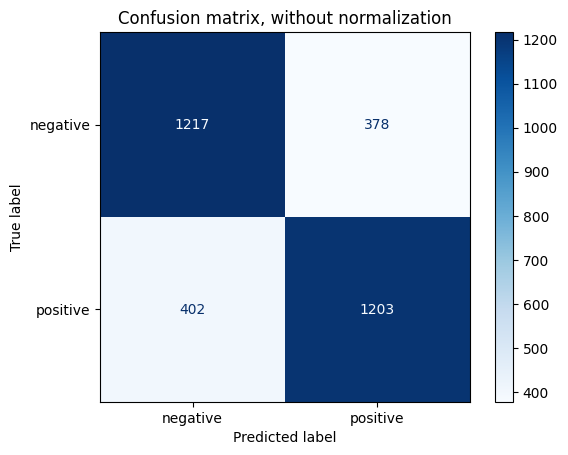

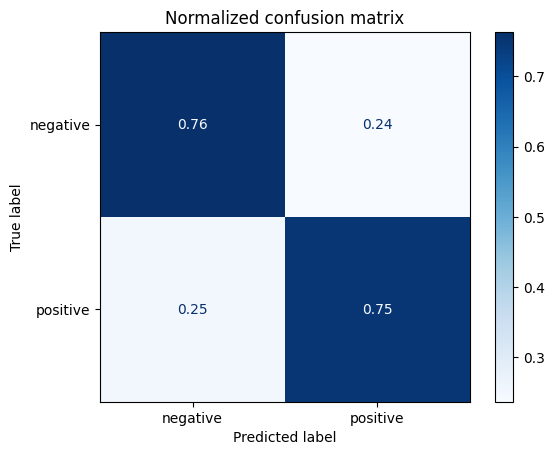

In [18]:
target_names=['negative', 'positive']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test,
                                 display_labels= target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [19]:
# Predict the test data
y_pred = pipeline.predict(X_test)
# Print out the report
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.75      0.76      0.76      1595
    positive       0.76      0.75      0.76      1605

    accuracy                           0.76      3200
   macro avg       0.76      0.76      0.76      3200
weighted avg       0.76      0.76      0.76      3200



## Results
The model is a fairily good model due to the F1 score being 76%. It could get a little better with some hyper tuning

## Model 2: Create pipeline that has grid search for hyperparameters and svc


In [40]:
#Due to time need to make the datasets even smaller
df = df.sample(frac=0.01, random_state=42)
X = df['text']
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print(f'X_train dimension: {X_train.shape}; y_train dimension: {y_train.shape}')
print(f'X_test dimension: {X_test.shape}; y_train dimension: {y_test.shape}')
#vounts of each
print(y_train.value_counts())
print(y_test.value_counts())

X_train dimension: (128,); y_train dimension: (128,)
X_test dimension: (32,); y_train dimension: (32,)
popularity
0    64
4    64
Name: count, dtype: int64
popularity
4    16
0    16
Name: count, dtype: int64


In [41]:
#time the code
t0 = time()
#tokenizer
# tfidf = TfidfVectorizer(tokenizer = spacy_tokenizer)
#create classifier
classifier = SVC()
#create the pipeline
pipeline = Pipeline(
    [
        ('cleaner', features()),
        ('vectorizer', TfidfVectorizer(tokenizer = spacy_tokenizer)),
        ('classifier', classifier)
    ]
)
#paramters
parameters = {
    'vectorizer__max_df': (0.5, 1.0),
    'vectorizer__ngram_range': ((1, 1), (1,2)),  # unigrams or bigrams
    'vectorizer__use_idf': (True, False),
    'classifier__C': (0.1, 1, 10),
    'classifier__kernel': ('linear', 'rbf'),
    'classifier__gamma': ('scale', 'auto')
}

#perform gridsearch
grid_search = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)
#time taken
print(f'Time taken: {np.round(time()-t0,2)} seconds')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extr

Time taken: 398.52 seconds


### Best parameters


In [42]:
print(f"Best score= {np.round(grid_search.best_score_,2)}")
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score= 0.57
Best parameters set:
	classifier__C: 1
	classifier__gamma: 'scale'
	classifier__kernel: 'rbf'
	vectorizer__max_df: 0.5
	vectorizer__ngram_range: (1, 1)
	vectorizer__use_idf: False


### Look at results

Confusion matrix, without normalization
[[9 7]
 [7 9]]
Normalized confusion matrix
[[0.5625 0.4375]
 [0.4375 0.5625]]


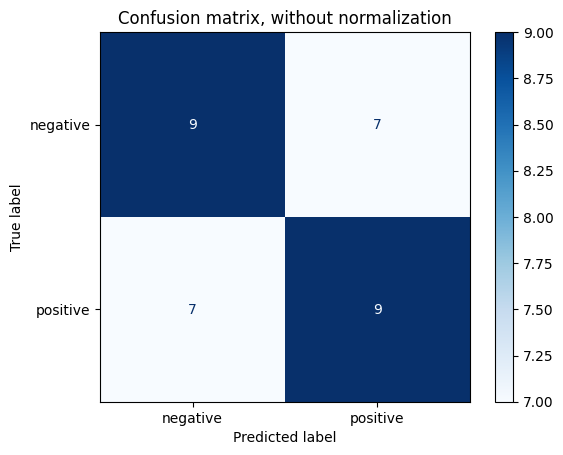

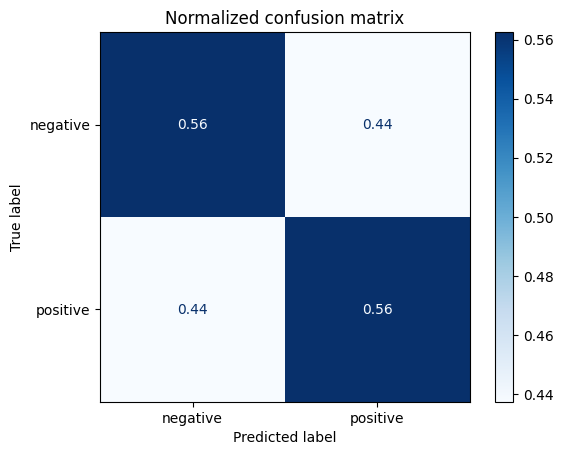

In [44]:
target_names=['negative','positive']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test,
                                 display_labels= target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [46]:
# Predict the test data
y_pred = grid_search.best_estimator_.predict(X_test)
# Print out the report
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.56      0.56      0.56        16
    positive       0.56      0.56      0.56        16

    accuracy                           0.56        32
   macro avg       0.56      0.56      0.56        32
weighted avg       0.56      0.56      0.56        32



### Results:
This model is not very good due to the extremely low volume of data that I used to save time. Had I been able to allocate more resources to be able to use more data, I believe the model would be much better

## Model 3: Build third model using pipeline, grid search and three models: logistic regression, svm, and random forest

In [47]:
class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator=SVC()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [48]:
lr = LogisticRegression()
rf = RandomForestClassifier()

In [55]:
#create the pipeline
pipeline = Pipeline(
    [
        ('cleaner', features()),
        ('vectorizer', TfidfVectorizer(tokenizer = spacy_tokenizer)),
        ('classifier', ClfSwitcher())
    ]
)

parameters = [
    {
    'vectorizer__max_df': ([1.0]),
    'vectorizer__norm': ('l1', 'l2'),
    'vectorizer__stop_words': ['english', None],
    'classifier__estimator': [SVC()],
    'classifier__estimator__C': (0.1, 1, 10),
    'classifier__estimator__kernel': ('linear', 'rbf'),
    'classifier__estimator__gamma': ('scale', 'auto')
    },
    {
    'vectorizer__max_df': ([1.0]),
    'vectorizer__norm': ('l1', 'l2'),
    'vectorizer__stop_words': ['english', None],
    'classifier__estimator': [LogisticRegression()],
    'classifier__estimator__C': [0.1, 1, 10],
    'classifier__estimator__penalty': ['l1', 'l2']
    },
    {
    'vectorizer__max_df': ([1.0]),
    'vectorizer__norm': ('l1', 'l2'),
    'vectorizer__stop_words': ['english', None],
    'classifier__estimator': [RandomForestClassifier()],
    'classifier__estimator__n_estimators': [100, 200, 300],
    'classifier__estimator__max_features': ['sqrt'],
    'classifier__estimator__max_depth': [10, 20, 30],
    }
]

#time to code
t0 = time()
#perform gridsearch
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)
#time taken
print(f'Time taken: {np.round(time()-t0,2)} seconds')

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make', 'whereaft'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make', 'whereaft'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

Time taken: 911.2 seconds


In [58]:
#print out best score
print(f"Best score= {np.round(grid_search.best_score_,2)}")
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score= 0.64
Best parameters set:
	classifier: ClfSwitcher(estimator=RandomForestClassifier(max_depth=30))
	classifier__estimator: RandomForestClassifier(max_depth=30)
	classifier__estimator__bootstrap: True
	classifier__estimator__ccp_alpha: 0.0
	classifier__estimator__class_weight: None
	classifier__estimator__criterion: 'gini'
	classifier__estimator__max_depth: 30
	classifier__estimator__max_features: 'sqrt'
	classifier__estimator__max_leaf_nodes: None
	classifier__estimator__max_samples: None
	classifier__estimator__min_impurity_decrease: 0.0
	classifier__estimator__min_samples_leaf: 1
	classifier__estimator__min_samples_split: 2
	classifier__estimator__min_weight_fraction_leaf: 0.0
	classifier__estimator__n_estimators: 100
	classifier__estimator__n_jobs: None
	classifier__estimator__oob_score: False
	classifier__estimator__random_state: None
	classifier__estimator__verbose: 0
	classifier__estimator__warm_start: False
	cleaner: <__main__.features object at 0x78b30b266a70>
	memo

In [60]:
# Predict the test data
y_pred = grid_search.best_estimator_.predict(X_test)
# Print out the report
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.62      0.50      0.55        16
    positive       0.58      0.69      0.63        16

    accuracy                           0.59        32
   macro avg       0.60      0.59      0.59        32
weighted avg       0.60      0.59      0.59        32



### Results

Similar to the second model, this model was not very good due to the low volumne of data. Had there been more data to train on this could have been a much better model